# Quantum Cosine Classifier

This notebook describes how quantum cosine classifier works in practice.

Classically, cosine classifier is defined as follows:


\begin{align}\label{equation:cosine classifier}
    Pr\Big(y^{(test)} = y_{b}\Big) = \frac{1}{2}+\frac{\Big[d\big(x_{b}, x^{(test)}\big)\Big]^2}{2}
\end{align}

where $(x_{b}, y_{b})$ is a random training example, $x^{(test)}$ the test point and $d(\cdot, \cdot)$ the cosine distance between $x_{b}$ and $x^{(test)}$.

Since the probability of belonging to a class depends on the squared cosine distance between the two vectors, the maximum dissimilarity occurs when training and test observations are orthogonal. In this case, the cosine classifier  assigns a uniform probability distribution in the two classes for $y^{(test)}$. This means that the cosine classifier performs well only if the test point belongs to the same class of the training point. 

## Quantum Implementation of the Cosine Classifier

The quantum circuit that implements the cosine classifier encodes data into three different registers: the training vector $x^{(i)}$, the training label $y^{(i)}$ and the test point $x^{(test)}$. One more qubit is used to store the prediction. 

The algorithm is made of the following three steps.

### Step 1: State Preparation

Data are encoded into three different quantum registers. Since each set of data ($x$ and $y$) is stored separately, the state preparation routine can be performed independently for each qubit.

$$ \left|\Phi_1\right\rangle = \Big( S_{x_{b}} \otimes S_{x^{(test)}} \otimes S_{y_{b}} \otimes  \mathbb{1}  \Big) \left|0\right\rangle \left|0\right\rangle \left|0\right\rangle \left|0\right\rangle  = \left|x_{b}\right\rangle \left|x^{(test)}\right\rangle \left|y_{b}\right\rangle \left|0\right\rangle
$$

where $S_{(x)}$ is the routine which encodes in the amplitudes of a qubit a $2$-dimensional real vector $x$.

### Step 2: Execution of the swap test

In the second step, the swap-test transforms the amplitudes of the qubit $y^{(test)}$ as a function of the squared cosine distance:

\begin{align}
\left|\Phi_2\right\rangle = & \big(\mathbb{1} \otimes \mathbb{1} \otimes \mathbb{1} \otimes H\big)
\big(\text{cswap} \otimes \mathbb{1} \otimes C \big) 
\big(\mathbb{1} \otimes \mathbb{1} \otimes \mathbb{1} \otimes H\big) 
\left|x_{b}\right\rangle \left|x^{(test)}\right\rangle \left|y_{b}\right\rangle \left|0\right\rangle \\ 
   =  & \frac{1}{2} 
   \Big(
   \big( \left|x_{b}\right\rangle \left|x^{(test)}\right\rangle + \left|x^{(test)}\right\rangle \left|x_{b}\right\rangle \big)\left|y_{b}\right\rangle  \left|0\right\rangle + 
  \big(\left|x_{b}\right\rangle \left|x^{(test)}\right\rangle - \left|x^{(test)}\right\rangle \left|x_{b}\right\rangle \big)\left|y_{b}\right\rangle  \left|1\right\rangle \Big)
\end{align}

where $H$ is the Hadamard gate, cswap is the controlled-swap operation which uses the fourth qubit (position of gate *C*) as control  qubit to swap $\left|x_{b}\right\rangle$ and $\left|x^{(test)}\right\rangle$.
After the execution of the swap test the probability to redout the basis state $\left|0\right\rangle$, that is the probability for the *test* observation to be classified in class $0$ is:

\begin{align}
    P(y^{(test)} = \left|0\right\rangle) = 
    \frac{1}{2}+\frac{|\langle x_{b}|x^{(test)} \rangle|^2}{2}
\end{align}

### Step 3: Controlled Pauli-*X* gate

The third step consists in applying a controlled Pauli-$X$ rotation using the control qubit that encodes the label of the training vector. This implies that $y^{(test)}$ is left untouched if  $x_{b}$ belongs to the class $0$. Otherwise,
the amplitudes of the $y^{(test)}$ qubit are exchanged,
and the probability $P(y^{(test)} = 1)$ is higher as the similarity between the two vectors increases.

$$
\left|\Phi_3\right\rangle = \big(\mathbb{1} \otimes \mathbb{1} \otimes \text{C-X} \big) \left|\Phi_2\right\rangle
$$

Thus, the probability amplitudes of the two basis states of $y^{(test)}$ lead to a classification rule that is equivalent to the classic cosine classifier.

# Quantum Implementation

To study the behaviour of the quantum cosine classifier $2000$ random datasets are generated. Each dataset is made up of a training point $(x_{b}, y_{b})$ and a test point $x^{(test)}$.

In [1]:
#Import modules and packages
import sys
sys.path.insert(1, '../')

from Utils import *
from modeling import * 

In [2]:
n_shots = 1000
n=1000
x = []
x_err = []
P0 = []
P1 = []

for i in np.arange(n):
    '''Random generated dataset'''
    x_train = [random.uniform(-1, 1), random.uniform(0, 1)]
    x_train_norm = normalize_custom(x_train)
    x_test = [random.uniform(-1, 1), random.uniform(0, 1)]
    x_test_norm = normalize_custom(x_test)

    '''Compute cosine distance and append it to x'''
    d_cos = cosine_similarity([x_train], [x_test])[0][0]
    x.append(d_cos)

    '''If x_train belongs to class 0'''
    qc = quantum_cosine_classifier(x_train_norm, x_test_norm, [1,0])
    r = exec_simulator(qc, n_shots)
    P_q = r['0']/n_shots
    P0.append(P_q)
    d_cos_err = np.sqrt(2*P_q-1)
    x_err.append( d_cos_err )


P0 = np.array(P0)
x = np.array(x)
x_err = np.array(x_err)

order = x.argsort()

x = x[order[::-1]]
P0 = P0[order[::-1]]
x_err = x_err[order[::-1]]

err = [ abs(x1 - x2) for (x1, x2) in zip(abs(x), x_err)]
err = np.array(err)
P1 = 1-P0

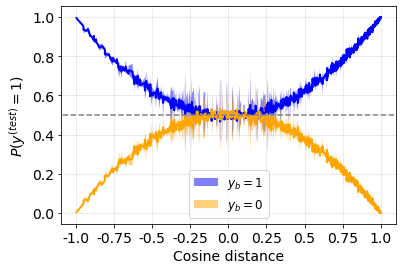

In [3]:
quantum_cos_random_data(x, P0, P1, err)

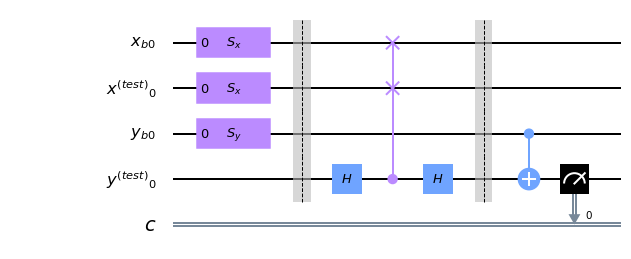

In [4]:
qc.draw(output='mpl', scale=.7, filename = 'output/cosine_circuit.png')